<a href="https://colab.research.google.com/github/tlchampion/drybeans/blob/main/notebooks/db_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install feature-engine

!pip uninstall xgboost -y
!pip install -U xgboost

# !pip uninstall scikit-learn -y
# !pip install -U scikit-learn

!pip install dython
!pip install scikit-optimize

Found existing installation: xgboost 1.6.0
Uninstalling xgboost-1.6.0:
  Successfully uninstalled xgboost-1.6.0
  Using cached xgboost-1.6.0-py3-none-manylinux2014_x86_64.whl (193.7 MB)


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn

from scipy.stats import chi2_contingency

from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import SmartCorrelatedSelection
from dython import nominal
from feature_engine.encoding import OrdinalEncoder as oe, MeanEncoder, CountFrequencyEncoder, RareLabelEncoder, OneHotEncoder as ohe
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.creation import CombineWithReferenceFeature
from feature_engine.outliers import ArbitraryOutlierCapper
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import os
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from joblib import dump, load
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, explained_variance_score, r2_score, mean_squared_error
from skopt import BayesSearchCV
import xgboost as xgb
from skopt.space import Real, Categorical, Integer, Space
from sklearn.preprocessing import FunctionTransformer



In [3]:
basedir = '/content/drive/MyDrive/Projects/drybeans'
try:
    os.makedirs(os.path.join(basedir, "data/02_interim"))
except FileExistsError:
    # directory already exists
    pass

try:
    os.makedirs(os.path.join(basedir, "data/03_processed"))
except FileExistsError:
    # directory already exists
    pass

try:
    os.makedirs(os.path.join(basedir, "models"))
except FileExistsError:
    # directory already exists
    pass

try:
    os.makedirs(os.path.join(basedir, "models/model1"))
except FileExistsError:
    # directory already exists
    pass




In [4]:
datapath = os.path.join(basedir, "data/01_raw/Dry_Bean_Dataset.xlsx") 
data = pd.read_excel(datapath, engine='openpyxl')


# Prepare Train and Test sets
Prior to conducting any EDA we will split the dataset into train and test 

In [13]:
x = data.iloc[:,0:16]
y = data.iloc[:,16]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42, stratify=y )

### Verify shapes for newly created data sets

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10888, 16) (2723, 16) (10888,) (2723,)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [22]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,10888.0,53018.072649,29288.343624,20420.000000,36324.000000,44665.000000,61360.500000,248424.000000
Perimeter,10888.0,855.023615,214.080717,524.736000,703.540250,795.059500,976.934750,1895.940000
MajorAxisLength,10888.0,320.047972,85.605004,183.601165,253.262149,297.130577,376.044012,726.373493
MinorAxisLength,10888.0,202.221553,44.968819,122.512653,175.715645,192.434802,216.772173,460.198497
AspectRation,10888.0,1.583165,0.246737,1.024868,1.433010,1.550842,1.706007,2.430306
Eccentricity,10888.0,0.750893,0.091890,0.218951,0.716262,0.764342,0.810192,0.911423
ConvexArea,10888.0,53737.747979,29734.530320,20684.000000,36708.250000,45208.500000,62372.750000,251082.000000
EquivDiameter,10888.0,252.995778,59.145280,161.243764,215.056163,238.472733,279.511385,562.408446
Extent,10888.0,0.749438,0.049045,0.555315,0.718305,0.759339,0.786510,0.866195
Solidity,10888.0,0.987131,0.004693,0.919246,0.985666,0.988272,0.990011,0.994677


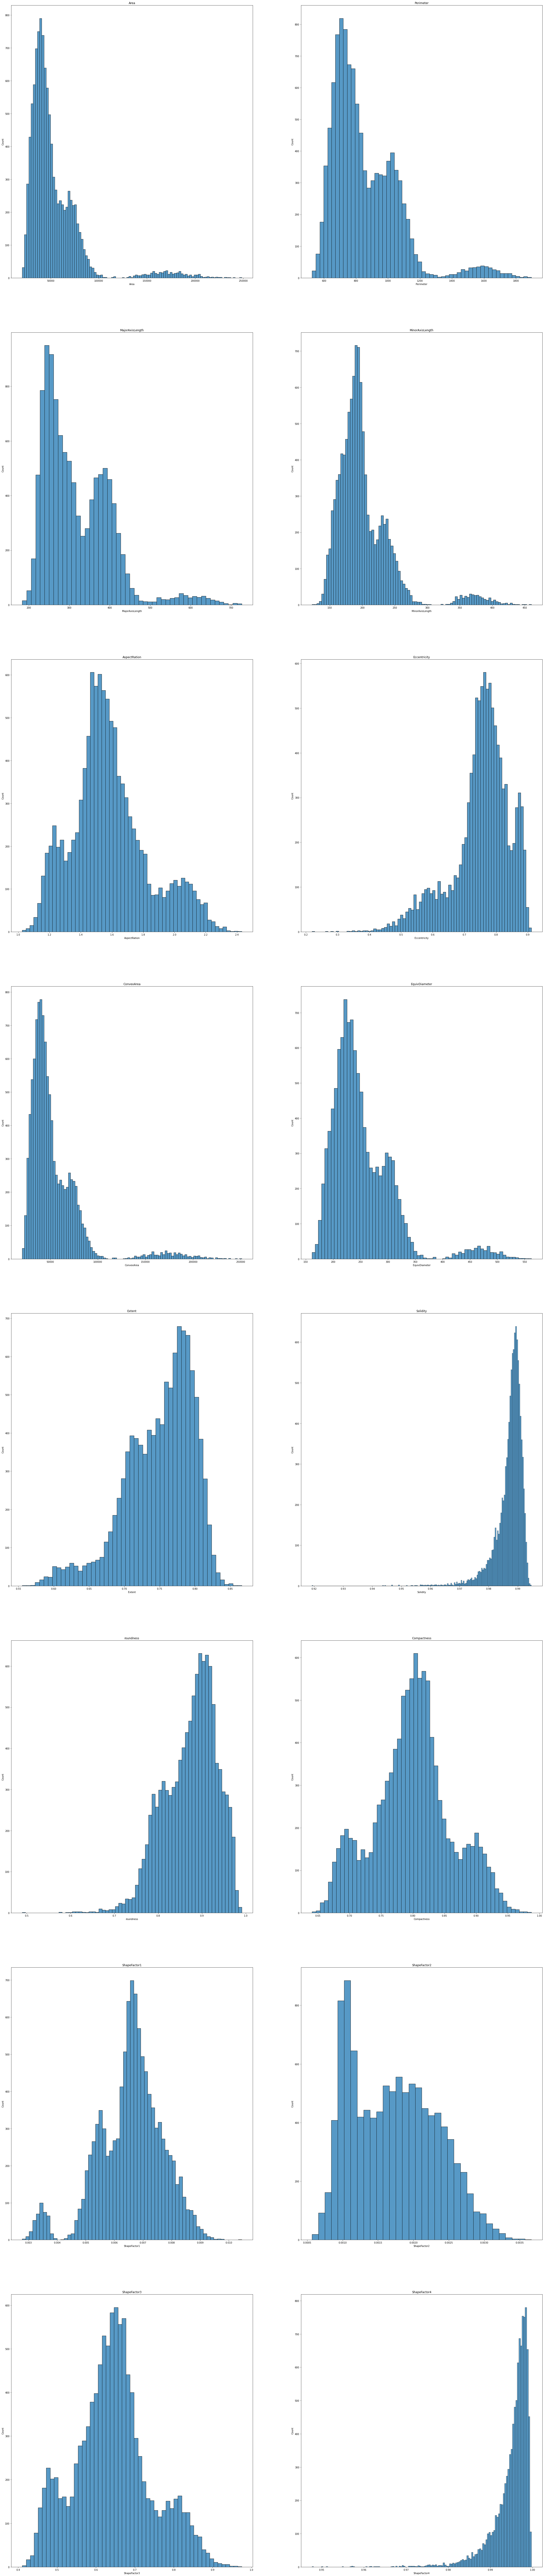

In [37]:
cols = X_train.columns
fig = plt.figure(figsize=(40,400))
for i in range (1,len(cols)+1):
    ax = plt.subplot(math.ceil(len(cols)),2,i)
    sns.histplot(x=X_train[cols[i-1]])
    plt.title(cols[i-1])
   
plt.show()

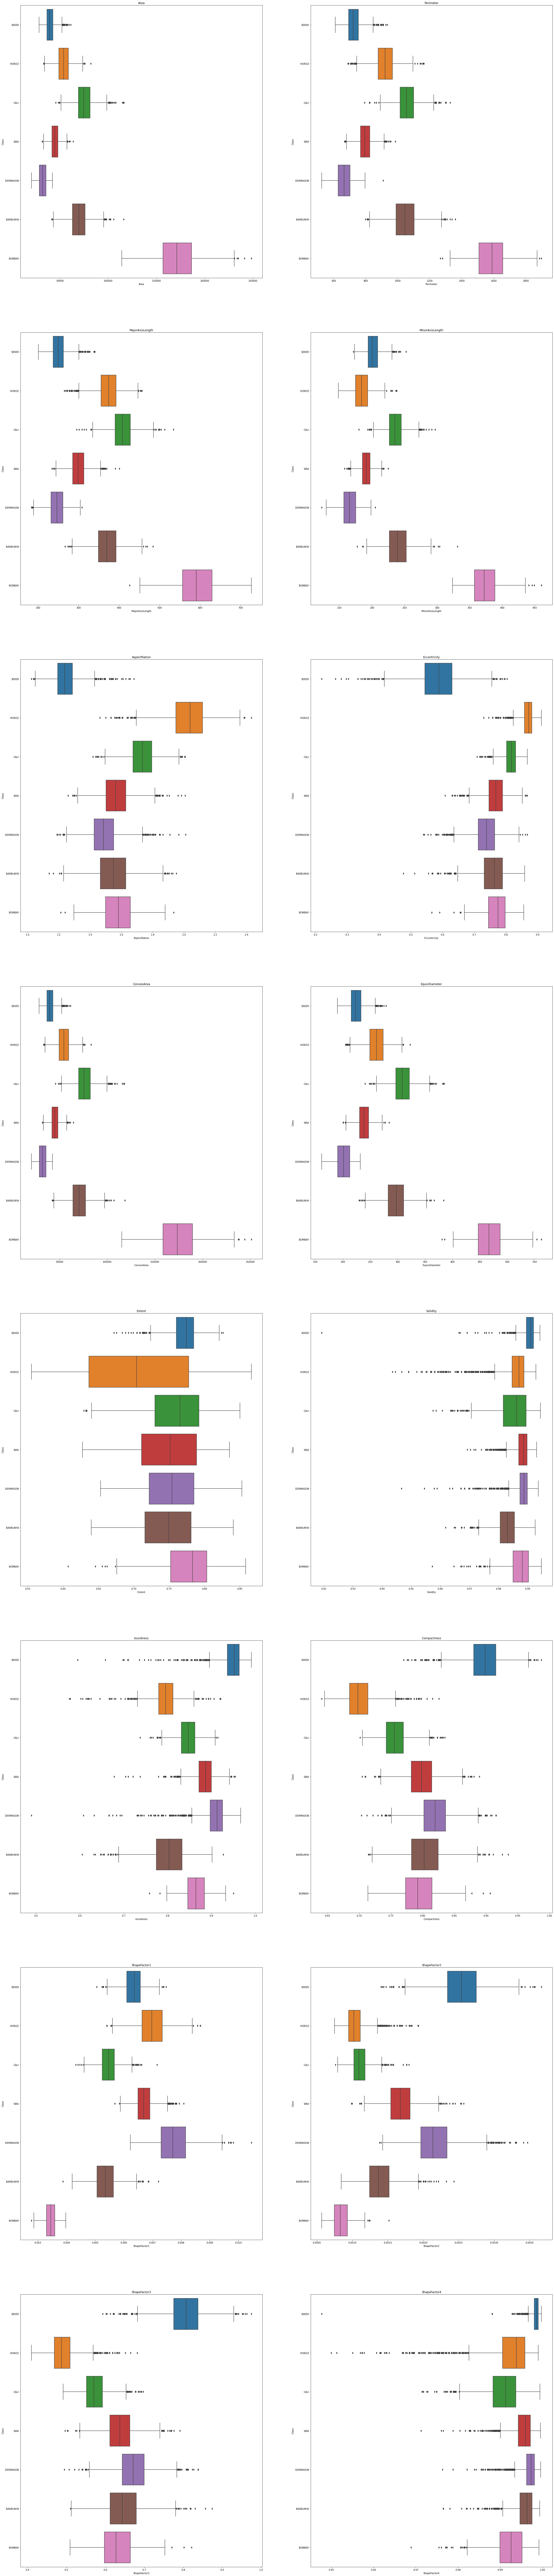

In [38]:
fig = plt.figure(figsize=(40,400))
for i in range (1,len(cols)+1):
    ax = plt.subplot(math.ceil(len(cols)),2,i)
    sns.boxplot(x=X_train[cols[i-1]], y=y_train)
    plt.title(cols[i-1])
plt.show()